In [4]:
# 1) Import
import numpy as np
import copy
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision.models import ResNet34_Weights
import torchvision.transforms as T

from PIL import Image
import skimage.io
import skimage.segmentation
import skimage.transform

import skimage.io 
import skimage.segmentation

from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances

In [5]:
# === LIME sederhana untuk ResNet-34 (PyTorch) ===
# 2) Device + model + preprocess + label
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights).to(DEVICE).eval()
preprocess = weights.transforms()                      # Resize + CenterCrop + ToTensor + Normalize
IMAGENET_CLASSES = weights.meta["categories"]

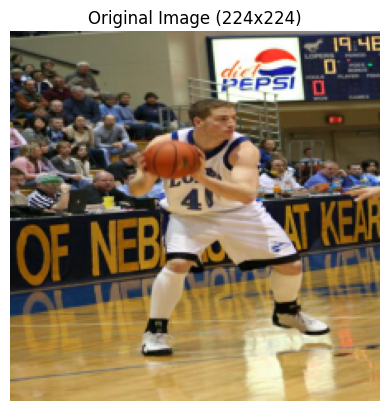

In [7]:
# 3) Ambil & siapkan gambar (resize ke 224x224 untuk segmentasi yang konsisten)
url = r"F:\UGM\Tugas\Tren Penelitian Sistem Cerdas\Week 5\dataset\basketball\ball.jpg"
Xi = skimage.io.imread(url)            # Hasil: numpy HxWxC, range [0..255] atau [0..1] tergantung sumber
if Xi.dtype != np.float32 and Xi.dtype != np.float64:
    Xi = Xi.astype(np.float32) / 255.0 # pastikan [0..1]
Xi = skimage.transform.resize(Xi, (224, 224), anti_aliasing=True)  # segmen di 224x224

plt.imshow(Xi)
plt.axis('off')
plt.title("Original Image (224x224)")
plt.show()

# Fungsi prediksi: terima numpy [0..1], kembalikan prob 1000 kelas
def predict_np(img_np):
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    x = preprocess(img_pil).unsqueeze(0).to(DEVICE)    # apply Resize/CenterCrop/ToTensor/Normalize
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    return probs

Top-5: [('basketball', 0.9914518594741821), ('volleyball', 0.008040047250688076), ('knee pad', 0.0004831325786653906), ('puck', 1.809936475183349e-05), ('soccer ball', 1.3489966477209236e-06)]


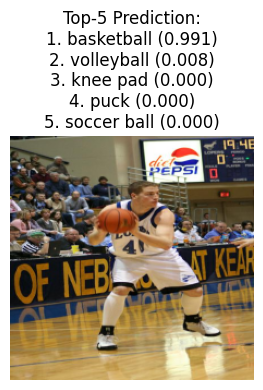

In [8]:
# 4) Prediksi awal + top-5
probs = predict_np(Xi)
top5_idx = probs.argsort()[-5:][::-1]
top5 = [(IMAGENET_CLASSES[i], float(probs[i])) for i in top5_idx]
print("Top-5:", top5)

def show_topk(pil, topk):
    plt.figure(figsize=(6,4))
    plt.imshow(pil); plt.axis("off")
    title = "Top-{} Prediction:\n".format(len(topk)) + "\n".join([f"{i+1}. {lbl} ({p:.3f})" for i,(lbl,p) in enumerate(topk)])
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_topk(Xi ,top5)

In [ ]:
# 5) Segmentasi jadi superpixel (Quickshift)
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.4) #ratio awalnya 0.2
num_superpixels = np.unique(superpixels).shape[0]
print("Jumlah superpixel:", num_superpixels)

Jumlah superpixel: 43


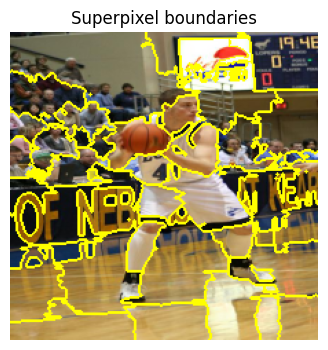

In [26]:
# --- Tampilkan boundary superpixel (garis kuning) ---
from skimage.segmentation import mark_boundaries

plt.figure(figsize=(4,4))
# Jika Xi sudah di [0..1] (versi PyTorch/ResNet34 yang kupakai):
plt.imshow(mark_boundaries(Xi, superpixels, color=(1,1,0)))
# Jika Xi kamu pakai preprocessing Inception [-1..1], gunakan ini:
# plt.imshow(mark_boundaries(Xi/2 + 0.5, superpixels, color=(1,1,0)))

plt.axis('off')
plt.title("Superpixel boundaries")
plt.show()

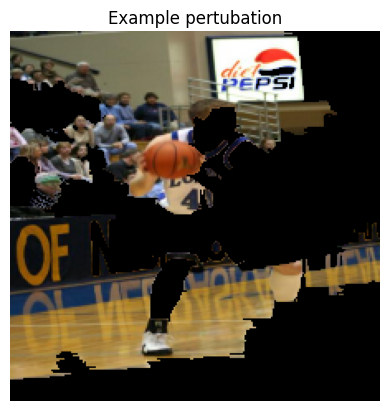

In [34]:
# 6) Buat perturbations (kombinasi ON/OFF superpixel)
np.random.seed(222)
num_perturb = 100
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

def perturb_image(img, perturbation, segments):
    """Matikan superpixel yang OFF (0) dengan mask 0; biarkan yang ON (1)."""
    active = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape, dtype=np.float32)
    for a in active:
        mask[segments == a] = 1.0
    return img * mask[..., np.newaxis]   # broadcast ke channel

# Contoh 1 perturbasi
plt.imshow(perturb_image(Xi, perturbations[0], superpixels))
plt.axis('off'); plt.title("Example pertubation")
plt.show()

In [35]:
# 7) Prediksi untuk semua perturbasi
predictions = []
for pert in perturbations:
    Xi_pert = perturb_image(Xi, pert, superpixels)
    predictions.append(predict_np(Xi_pert))
predictions = np.array(predictions)   # shape: (num_perturb, 1000)

In [36]:
# 8) Bobot lokal (RBF) terhadap "gambar asli" (semua superpixel ON)
original = np.ones((1, num_superpixels))
dists = pairwise_distances(perturbations, original, metric='cosine').ravel()
kernel_width = 0.25
weights_lime = np.sqrt(np.exp(-(dists**2) / (kernel_width**2)))   # bobot lebih besar jika mirip asli

In [37]:
# 9) Fit model linear lokal untuk kelas top-1
class_to_explain = top5_idx[0]
y = predictions[:, class_to_explain]                         # target: prob kelas top-1
lin = LinearRegression()
lin.fit(perturbations, y, sample_weight=weights_lime)
coeff = lin.coef_                                            # pentingnya tiap superpixel

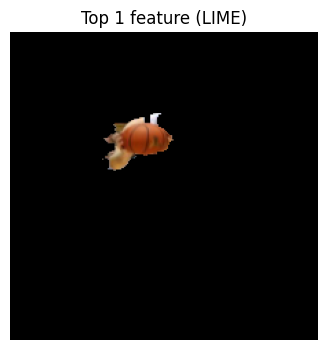

Kelas dijelaskan: basketball
Top superpixel index: [14]


In [45]:
# 10) Ambil superpixel paling penting & tampilkan
num_top_features = 1
top_features = np.argsort(coeff)[-num_top_features:]

mask = np.zeros(num_superpixels, dtype=np.float32)
mask[top_features] = 1.0
Xi_explain = perturb_image(Xi, mask, superpixels)

plt.figure(figsize=(10,4))
# plt.subplot(1,2,1); plt.imshow(Xi); plt.axis('off'); plt.title("Asli")
plt.subplot(1,2,2); plt.imshow(Xi_explain); plt.axis('off'); plt.title(f"Top {num_top_features} feature (LIME)")
plt.show()

print("Kelas dijelaskan:", IMAGENET_CLASSES[class_to_explain])
print("Top superpixel index:", top_features.tolist())

In [42]:
# === Letakkan SETELAH coeff dihitung (#9) ===
# Buat Xi_display untuk visual (pastikan [0..1])
Xi_display = Xi.copy()
if Xi_display.min() < 0.0 or Xi_display.max() > 1.0:
    Xi_display = np.clip((Xi_display/2.0) + 0.5, 0, 1)

# Mapping posisi-koef -> label superpixel yang ada di 'superpixels'
sp_ids = np.unique(superpixels)        # label unik di peta superpixel (panjang = num_superpixels)
order_pos = np.argsort(coeff)[::-1]    # urutan posisi berdasarkan kepentingan (desc)
order_labels = sp_ids[order_pos]       # inilah yang dipakai untuk masking (label, bukan posisi)

predict_np_simple = predict_np

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mask_with_mean(img, segments, remove_labels):
    mean_color = img.mean(axis=(0,1), keepdims=True)
    m = np.isin(segments, list(remove_labels))[:, :, None]
    return np.where(m, mean_color, img)

def apply_mask_keep_only(img, segments, keep_labels):
    # alternatif: tampilkan hanya keep_labels, yang lain jadi mean
    mean_color = img.mean(axis=(0,1), keepdims=True)
    keep = np.isin(segments, list(keep_labels))[:, :, None]
    return np.where(keep, img, mean_color)

def show_topk_effect(Xi_display, superpixels, order_labels, K=1, mode="deletion"):
    sp_all = set(np.unique(superpixels))
    topK = set(order_labels[:K])

    if mode == "deletion":
        # HAPUS top-K → remove = topK
        img_k = mask_with_mean(Xi_display, superpixels, remove_labels=topK)
        title = f"Deletion: top-{K}"
    else:  # "insertion"
        # TAMPILKAN hanya top-K → remove = semua - topK
        remove = sp_all - topK
        img_k = mask_with_mean(Xi_display, superpixels, remove_labels=remove)
        # (atau pakai apply_mask_keep_only(Xi_display, superpixels, topK))
        title = f"Insertion: top-{K}"

    p_orig = predict_np_simple(Xi_display)[class_to_explain]
    p_k    = predict_np_simple(img_k)[class_to_explain]

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(np.clip(Xi_display,0,1)); plt.axis('off')
    plt.title(f"Original\nprob={p_orig:.3f}")
    plt.subplot(1,2,2); plt.imshow(np.clip(img_k,0,1)); plt.axis('off')
    plt.title(f"{title}\nprob={p_k:.3f}")
    plt.tight_layout(); plt.show()

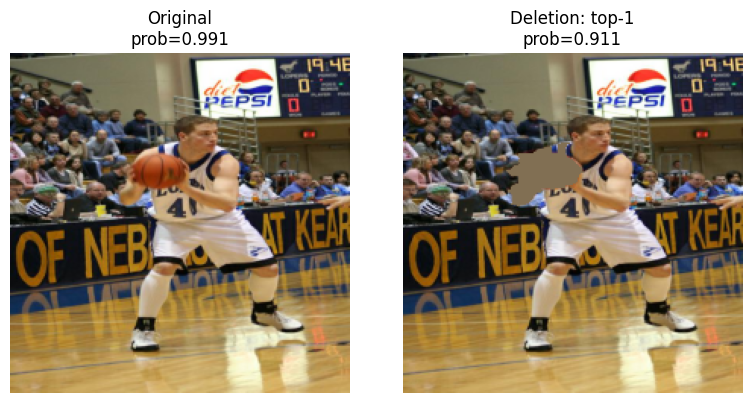

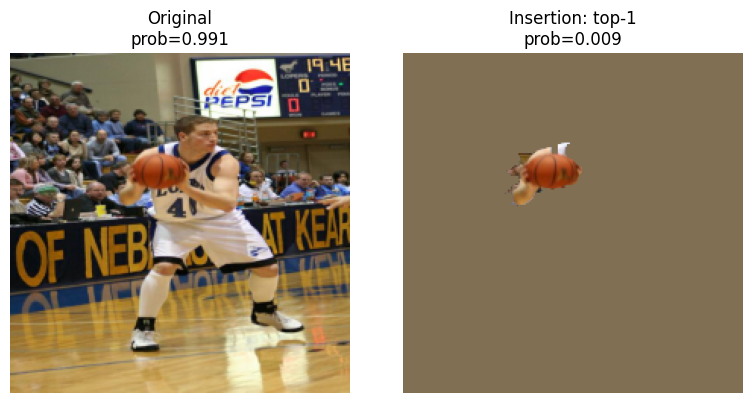

In [44]:
# Pastikan order_labels sudah benar: sp_ids = np.unique(superpixels); order = np.argsort(coeff)[::-1]; order_labels = sp_ids[order]

show_topk_effect(Xi_display, superpixels, order_labels, K=1, mode="deletion")   # hapus top-1 (benar)
show_topk_effect(Xi_display, superpixels, order_labels, K=1, mode="insertion")  # tampilkan top-1 (benar)
